*Original code: Beating the Benchmark from West Nile Virus Prediction @ Kaggle by Abhihsek. Modified by Brendan Lane*

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution1D, MaxPooling1D
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import Adam
from keras.initializers import *

%matplotlib inline

/home/raven/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load dataset 
train = pd.read_csv('../assets/train.csv')
test = pd.read_csv('../assets/test.csv')
sample = pd.read_csv('../assets/sampleSubmission.csv')
weather = pd.read_csv('../assets/weather.csv')

In [3]:
# Not using codesum for this benchmark
weather.drop('CodeSum', axis='columns', inplace=True)

In [4]:
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

In [5]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', -1)
weather = weather.replace(' T', -1)
weather = weather.replace('  T', -1)

In [6]:
# Functions to extract month and day from dataset
# You can also use parse_dates of Pandas.
def create_year(x):
    return x.split('-')[0]
def create_month(x):
    return x.split('-')[1]
def create_day(x):
    return x.split('-')[2]

train['month'] = train.Date.apply(create_month)
train['day'] = train.Date.apply(create_day)
train['year'] = train.Date.apply(create_year)

test['month'] = test.Date.apply(create_month)
test['day'] = test.Date.apply(create_day)
test['year'] = test.Date.apply(create_year)

In [7]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [8]:
# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')
train = train.drop(['Date'], axis = 1)
test = test.drop(['Date'], axis = 1)

In [9]:
# Convert categorical data to numbers
lbl = LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

In [10]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [11]:
# covert all data types to floats
train = train.astype(float)
test = test.astype(float)

In [12]:
## feature engineering
# Temperature difference
train['temp_delta_x'] = train.Tmax_x - train.Tmin_x
train['temp_delta_y'] = train.Tmax_y - train.Tmin_y
train['temp_delta_x'] = train.Tmax_x - train.Tmin_x
train['temp_delta_y'] = train.Tmax_y - train.Tmin_y
test['temp_delta_x'] = test.Tmax_x - test.Tmin_x
test['temp_delta_y'] = test.Tmax_y - test.Tmin_y
test['temp_delta_x'] = test.Tmax_x - test.Tmin_x
test['temp_delta_y'] = test.Tmax_y - test.Tmin_y

In [13]:
# Is raining?
train['israining_x'] = (train.PrecipTotal_x > 0).astype(int)
train['israining_y'] = (train.PrecipTotal_y > 0).astype(int)
test['israining_x'] = (test.PrecipTotal_x > 0).astype(int)
test['israining_y'] = (test.PrecipTotal_y > 0).astype(int)

In [14]:
# Length of sunlight
train['sunlight'] = train.Sunset_x - train.Sunrise_x
test['sunlight'] = test.Sunset_x - test.Sunrise_x

In [15]:
# Replace outliers with median value
train.WetBulb_x = train.WetBulb_x.apply(lambda x: train.WetBulb_x.median() if x < 0 else x)
test.WetBulb_x = test.WetBulb_x.apply(lambda x: test.WetBulb_x.median() if x < 0 else x)

train.StnPressure_x = train.StnPressure_x.apply(lambda x: train.StnPressure_x.median() if x < 0 else x)
test.StnPressure_x = test.StnPressure_x.apply(lambda x: test.StnPressure_x.median() if x < 0 else x)

In [16]:
# Relative humidity approximation
train['RH'] = 100 - (25 / 9) * (train.Tavg_x - train.DewPoint_x)
test['RH'] = 100 - (25 / 9) * (test.Tavg_x - test.DewPoint_x)

In [17]:
# Is heat wave?
train['isheat'] = (train.Heat_x > 0).astype(float)
test['isheat'] = (test.Heat_x > 0).astype(float)

In [18]:
# Vectorize resultant wind into north and east components
wind_dir_north_x = train.ResultDir_x.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_x = train.ResultDir_x.apply(lambda x: np.cos(np.deg2rad(x)))
train['wind_north_x'] = wind_dir_north_x * train.ResultSpeed_x
train['wind_east_x'] = wind_dir_east_x * train.ResultSpeed_x

wind_dir_north_y = train.ResultDir_y.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_y = train.ResultDir_y.apply(lambda x: np.cos(np.deg2rad(x)))
train['wind_north_y'] = wind_dir_north_y * train.ResultSpeed_y
train['wind_east_y'] = wind_dir_east_y * train.ResultSpeed_y

wind_dir_north_x = test.ResultDir_x.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_x = test.ResultDir_x.apply(lambda x: np.cos(np.deg2rad(x)))
test['wind_north_x'] = wind_dir_north_x * test.ResultSpeed_x
test['wind_east_x'] = wind_dir_east_x * test.ResultSpeed_x

wind_dir_north_y = test.ResultDir_y.apply(lambda x: np.sin(np.deg2rad(x)))
wind_dir_east_y = test.ResultDir_y.apply(lambda x: np.cos(np.deg2rad(x)))
test['wind_north_y'] = wind_dir_north_y * test.ResultSpeed_y
test['wind_east_y'] = wind_dir_east_y * test.ResultSpeed_y

In [19]:
# Vectorize average wind into north and east components
train['avg_wind_north_x'] = wind_dir_north_x * train.AvgSpeed_x
train['avg_wind_east_x'] = wind_dir_east_x * train.AvgSpeed_x

train['avg_wind_north_y'] = wind_dir_north_y * train.AvgSpeed_y
train['avg_wind_east_y'] = wind_dir_east_y * train.AvgSpeed_y

test['avg_wind_north_x'] = wind_dir_north_x * test.AvgSpeed_x
test['avg_wind_east_x'] = wind_dir_east_x * test.AvgSpeed_x

test['avg_wind_north_y'] = wind_dir_north_y * test.AvgSpeed_y
test['avg_wind_east_y'] = wind_dir_east_y * test.AvgSpeed_y

In [20]:
train = pd.concat([train.reset_index(), (pd.get_dummies(train.year)).reset_index(), (pd.get_dummies(train.month)).reset_index(), (pd.get_dummies(train.Species)).reset_index()], axis='columns')
test = pd.concat([test.reset_index(), (pd.get_dummies(test.year)).reset_index(), (pd.get_dummies(test.month)).reset_index(), (pd.get_dummies(test.Species)).reset_index()], axis='columns')

In [21]:
drop_list = ['PrecipTotal_x', 'PrecipTotal_y', 'Sunrise_x', 'Sunset_x',
             'Heat_x', 'Depth_x', 'SnowFall_x', 'ResultDir_x', 'ResultSpeed_x',
             'ResultDir_y', 'ResultSpeed_y', 'AvgSpeed_x', 'AvgSpeed_y', 'year',
             'month', 'Species']

train.drop(drop_list, axis='columns', inplace=True)
test.drop(drop_list, axis='columns', inplace=True)

In [22]:
# Set dependent (y) and indepedent (X) variables
y = train.WnvPresent
X = train.drop('WnvPresent', axis='columns')

In [23]:
# Baseline accuracy
1 - y.mean()

0.9475537787930707

In [24]:
# Scale X for modeling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [25]:
# Train/test split for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [26]:
# Random forest
cross_val_score(RandomForestClassifier(max_depth=4, max_features=5), X_train, y_train,
                cv=5, n_jobs=-1, verbose=0).mean()

0.9475250626167533

*Doesn't break baseline. What is happening?*

In [27]:
# Confustion matrix
clf = RandomForestClassifier(max_depth=4, max_features=5)
clf.fit(X_train, y_train)
confusion_matrix(y_test, clf.predict(X_test))

array([[1992,    0],
       [ 110,    0]])

*The model is maximizing accuracy by predicting "No" everytime. This is the result of have unbalanced classes.*

In [28]:
# Dataframe of positive West Nile results
pos_train = train[train.WnvPresent == 1]

In [29]:
# Oversampled unrepresented class
traino = pd.concat([train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train, pos_train], axis=0)

In [30]:
# Oversampled train/test split
yo = traino.WnvPresent
Xo = traino.drop('WnvPresent', axis='columns')
Xo = pd.DataFrame(scaler.fit_transform(Xo), columns=Xo.columns)
X_traino, X_testo, y_traino, y_testo = train_test_split(Xo, yo, test_size=0.2, random_state=42, stratify=yo)

### We should maximize recall

In [31]:
clf = RandomForestClassifier(max_depth=4, max_features=7)
clf.fit(X_traino, y_traino)
print(confusion_matrix(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test), target_names=['No', 'Yes']))

[[1479  513]
 [  35   75]]
             precision    recall  f1-score   support

         No       0.98      0.74      0.84      1992
        Yes       0.13      0.68      0.21       110

avg / total       0.93      0.74      0.81      2102



Train on 15898 samples, validate on 2102 samples
Epoch 1/50
15898/15898 [==============================] - 3s 217us/step - loss: 0.5077 - acc: 0.7427 - val_loss: 0.7146 - val_acc: 0.5547
Epoch 2/50
15898/15898 [==============================] - 3s 203us/step - loss: 0.4329 - acc: 0.7978 - val_loss: 0.6629 - val_acc: 0.5756
Epoch 3/50
15898/15898 [==============================] - 2s 154us/step - loss: 0.4081 - acc: 0.8078 - val_loss: 0.7126 - val_acc: 0.5461
Epoch 4/50
15898/15898 [==============================] - 2s 152us/step - loss: 0.3915 - acc: 0.8214 - val_loss: 0.6313 - val_acc: 0.5804
Epoch 5/50
15898/15898 [==============================] - 2s 143us/step - loss: 0.3812 - acc: 0.8272 - val_loss: 0.6893 - val_acc: 0.5690
Epoch 6/50
15898/15898 [==============================] - 3s 162us/step - loss: 0.3672 - acc: 0.8345 - val_loss: 0.6460 - val_acc: 0.5875
Epoch 7/50
15898/15898 [==============================] - 3s 197us/step - loss: 0.3591 - acc: 0.8379 - val_loss: 0.7005 - v

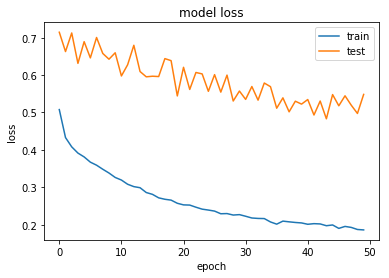

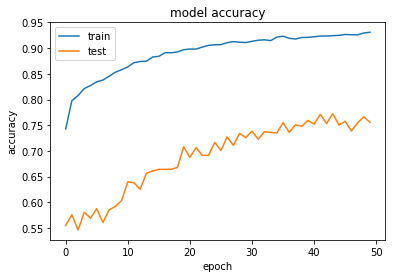

0.7554709802458788

In [32]:
model = Sequential()
input_units = X_train.shape[1]
hidden_units = input_units

model.add(Dense(hidden_units * 2,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(hidden_units * 2,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10,
                input_dim=input_units,
                activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

hist = model.fit(X_traino, y_traino,
                 validation_data=(X_test, y_test),
                 epochs=50,
                 batch_size=64,
                 shuffle=True)

plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best') ## I love this loc = 'best' command.
plt.show()
plt.figure()
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()
hist.history['val_acc'][-1]

In [34]:
for threshold in np.linspace(0, 1, 20):
    print('Threshold: {}'.format(threshold))
    print('Confusion Matrix')
    print(confusion_matrix(y_test, (model.predict(X_test) > threshold).astype(float)))
    print(classification_report(y_test, (model.predict(X_test) > threshold).astype(float), target_names=['No', 'Yes']))
    print('*******************************\n')

Threshold: 0.0
Confusion Matrix
[[  26 1966]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.01      0.03      1992
        Yes       0.05      1.00      0.10       110

avg / total       0.95      0.06      0.03      2102

*******************************

Threshold: 0.05263157894736842
Confusion Matrix
[[1218  774]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.61      0.76      1992
        Yes       0.12      1.00      0.22       110

avg / total       0.95      0.63      0.73      2102

*******************************

Threshold: 0.10526315789473684
Confusion Matrix
[[1294  698]
 [   0  110]]
             precision    recall  f1-score   support

         No       1.00      0.65      0.79      1992
        Yes       0.14      1.00      0.24       110

avg / total       0.95      0.67      0.76      2102

*******************************

Threshold: 0.15789473684210525
Confusion Matrix

/home/raven/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

In [39]:
clf = LogisticRegression()
clf.fit(X_traino, y_traino)
print(confusion_matrix(y_test, clf.predict(X_test)))
print(classification_report(y_test, clf.predict(X_test), target_names=['No', 'Yes']))
clf.score(X_test, y_test)

[[1045  947]
 [   4  106]]
             precision    recall  f1-score   support

         No       1.00      0.52      0.69      1992
        Yes       0.10      0.96      0.18       110

avg / total       0.95      0.55      0.66      2102



0.5475737392959087

In [96]:
parms = {
    'C': np.logspace(-6, 1, 50),
    'class_weight': [{0: 50.0, 1: 1.0}, {0: 25.0, 1: 1.0}, 
                     {0: 10.0, 1: 1.0}, {0: 10.0, 1: 1.0}]
}
gs = GridSearchCV(estimator=LogisticRegression(), param_grid=parms,
                  cv=2, n_jobs=-1, verbose=1)

In [97]:
gs.fit(X_train, y_train)
print(gs.best_params_)
print(gs.best_score_)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.0s


{'C': 1e-06, 'class_weight': {0: 50.0, 1: 1.0}}
0.947405997144217


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   14.1s finished
